In [2]:
!pip3 install pymatgen

     |████████████████████████████████| 2.8MB 13.2MB/s 
     |████████████████████████████████| 112kB 53.2MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 25.9MB 1.7MB/s 
     |████████████████████████████████| 296kB 48.7MB/s 
     |████████████████████████████████| 13.2MB 50.7MB/s 
     |████████████████████████████████| 256kB 60.1MB/s 
     |████████████████████████████████| 552kB 48.8MB/s 
  Created wheel for pymatgen: filename=pymatgen-2020.12.3-cp36-cp36m-linux_x86_64.whl size=3588503 sha256=f2c09b34e29d650da66d6d6e4835b8918f12d375da5be0c6cc7d1e03d2c1c3aa
  Stored in directory: /root/.cache/pip/wheels/cc/bf/e5/59995a59a4b574944ecb4ce504457f710c9333a9052c2e0163
Successfully built pymatgen
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing insta

In [3]:
!pip install torch_optimizer

     |████████████████████████████████| 71kB 7.4MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/CGCNN

/content/drive/MyDrive/CGCNN


In [6]:
ls

band-gap.pth.tar  cgcnn/  cif_merge/  hoip_band_gap.csv  material-data/  T0


In [7]:
import os
import csv
import time
import pymatgen
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from random import sample
from sklearn import metrics
from torch.autograd import Variable
from torch.utils.data import DataLoader
from cgcnn.data import CIFData
from cgcnn.data import collate_pool, get_train_val_test_loader
from cgcnn.model import CrystalGraphConvNet
from torchsummary import summary
import torch_optimizer as optim
gpu_boole = torch.cuda.is_available()

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class Normalizer(object):
    """Normalize a Tensor and restore it later. """
    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

def mae(prediction, target):
    """
    Computes the mean absolute error between prediction and target
    Parameters
    ----------
    prediction: torch.Tensor (N, 1)
    target: torch.Tensor (N, 1)
    """
    return torch.mean(torch.abs(target - prediction))

def rmse(prediction, target):
    """
    Computes the root mean square error between prediction and target
    Parameters
    ----------
    prediction: torch.Tensor(N, 1)
    target: torch.Tensor(N, 1)
    """

    return torch.sqrt(torch.mean(torch.square(target - prediction)))

In [9]:
def freezelayer(model, embed=False, conv=False, pool=False, fc=False):
  
  ## freeze individual layer ##
  
  i = 0
  for child in model.children():
    if i == 0:
      if embed:
        for param in child.parameters():
          param.requires_grad = False
      else:
        for param in child.parameters():
          param.requires_grad = True
      
    if i == 1:
      if conv:
        for param in child.parameters():
          param.requires_grad = False
      else:
        for param in child.parameters():
          param.requires_grad = True

    if i == 2:
      if pool:
        for param in child.parameters():
          param.requires_grad = False
      else:
        for param in child.parameters():
          param.requires_grad = True
    
    if i == 4:
      if fc:
        for param in child.parameters():
          param.requires_grad = False
      else:
        for param in child.parameters():
          param.requires_grad = True
    i += 1


def freezeBN(model, freeze=False):

  ## freeze batch norm layers 
  ## True: freeze all BN layers 
  ## False: freeze all but BN layers

  for name, params in model.named_parameters():
    if freeze:
      if 'bn' in name:
        params.requires_grad = False
    elif name.find('bn') == -1:
      params.requires_grad = False


def unfreeze(model):

  ## unfreeze the entire model

  for param in model.parameters():
      param.requires_grad = True

In [12]:
def train(model, nepochs=200, optimizer=torch.optim.Adam(
    model.parameters(), lr=1e-3), criterion = nn.SmoothL1Loss()):
  
  t0 = time.time()
  
  for epoch in range(nepochs):

    loss_train, mae_train = update(model, train_loader)
    loss_test, mae_test = evaluate(model, test_loader)
    loss_val, mae_val = evaluate(model, val_loader)
    
    losses_train.append(loss_train)
    losses_val.append(loss_val)
    
    error_train.append(mae_train)
    error_val.append(mae_val)

    if epoch % 10 == 0:
      t = time.time()
      print('Epoch %d:' %epoch, 'MAE for training: %.4f validation %.4f' %(mae_train, mae_val))


def update(model, loader):
  loss_train = []
  mae_errors = AverageMeter()

  for i, (input, target, batch_cif_ids) in enumerate(loader):
    model.train()
    input_var = (input[0].cuda(), input[1].cuda(), input[2].cuda(),
                  [crys_idx.cuda() for crys_idx in input[3]])
    target_normed = normalizer.norm(target).cuda()
    output = model(*input_var)
    loss = criterion(output, target_normed)
    loss_train.append(loss.data.cpu())
    
    optimizer.zero_grad()  
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      error = mae(normalizer.denorm(output.data.cpu()), target)
      mae_errors.update(error, target.size(0))  
    
  return np.mean(loss_train), float(mae_errors.avg)


def evaluate(model, loader):
  losses = []
  mae_errors = AverageMeter()
  
  model.eval()
  with torch.no_grad():
    for i, (input, target, batch_cif_ids) in enumerate(loader):
      if gpu_boole:
        input_var = (input[0].cuda(), input[1].cuda(), input[2].cuda(),
                      [crys_idx.cuda() for crys_idx in input[3]])
      else:
        input_var = input
      
      target_normed = normalizer.norm(target)
      if gpu_boole:
        target_normed = target_normed.cuda()
      
      output = model(*input_var)
      loss = criterion(output, target_normed)
      losses.append(loss.data.cpu())
      error = mae(normalizer.denorm(output.data.cpu()), target)
      mae_errors.update(error, target.size(0))
    
  return np.mean(losses), float(mae_errors.avg)


In [10]:
dataset = CIFData('cif_merge')
collate_fn = collate_pool
train_loader, val_loader, test_loader = get_train_val_test_loader(dataset=dataset, collate_fn=collate_fn, batch_size=10, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, pin_memory=gpu_boole, num_workers=0, return_test=True, train_size=None, test_size=None, val_size=None)
structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

/usr/local/lib/python3.6/dist-packages/pymatgen/io/cif.py:745: UserWarning:

No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.

/usr/local/lib/python3.6/dist-packages/pymatgen/io/cif.py:1194: UserWarning:

Issues encountered while parsing CIF: No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.



In [11]:
model_checkpoint = torch.load('band-gap.pth.tar')
model_args = model_checkpoint['args']
model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len=model_args['atom_fea_len'],
                            n_conv=model_args['n_conv'], h_fea_len=model_args['h_fea_len'], n_h=model_args['n_h'],
                            classification=False)

normalizer = Normalizer(torch.zeros(3))
model.load_state_dict(model_checkpoint['state_dict'])
normalizer.load_state_dict(model_checkpoint['normalizer'])

In [34]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size(), model.state_dict()[param_tensor].requires_grad)

Model's state_dict:
embedding.weight 	 torch.Size([64, 92]) False
embedding.bias 	 torch.Size([64]) False
convs.0.fc_full.weight 	 torch.Size([128, 169]) False
convs.0.fc_full.bias 	 torch.Size([128]) False
convs.0.bn1.weight 	 torch.Size([128]) False
convs.0.bn1.bias 	 torch.Size([128]) False
convs.0.bn1.running_mean 	 torch.Size([128]) False
convs.0.bn1.running_var 	 torch.Size([128]) False
convs.0.bn1.num_batches_tracked 	 torch.Size([]) False
convs.0.bn2.weight 	 torch.Size([64]) False
convs.0.bn2.bias 	 torch.Size([64]) False
convs.0.bn2.running_mean 	 torch.Size([64]) False
convs.0.bn2.running_var 	 torch.Size([64]) False
convs.0.bn2.num_batches_tracked 	 torch.Size([]) False
convs.1.fc_full.weight 	 torch.Size([128, 169]) False
convs.1.fc_full.bias 	 torch.Size([128]) False
convs.1.bn1.weight 	 torch.Size([128]) False
convs.1.bn1.bias 	 torch.Size([128]) False
convs.1.bn1.running_mean 	 torch.Size([128]) False
convs.1.bn1.running_var 	 torch.Size([128]) False
convs.1.bn1.num_bat

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
losses_train, losses_val = [], []
error_train, error_val = [], []

criterion = nn.SmoothL1Loss()

## Phase I
## First add one linear layer on the top and train the head
model._modules['fc_out'] = nn.Linear(32, 16)
model.add_module('relu', nn.ReLU())
model.add_module('last', nn.Linear(16, 1))
unfreeze(model)
freezelayer(model, embed=True, conv=True, pool=True, fc=False)

if gpu_boole:
    model.cuda()

params = list(model.parameters())
for n in range(len(params)):
  print(params[n].shape, params[n].requires_grad)

torch.Size([64, 92]) False
torch.Size([64]) False
torch.Size([128, 169]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([128, 169]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([128, 169]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([128, 169]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([32, 64]) False
torch.Size([32]) False
torch.Size([16, 32]) True
torch.Size([16]) True
torch.Size([1, 16]) True
torch.Size([1]) True


In [15]:
## Asign a larger learning rate to the added layer
optimizer = torch.optim.Adam([
        {"params": model.fc_out.parameters(), "lr": 1e-3},
        {"params": model.last.parameters(), "lr": 1e-2}
        ])

train(model, nepochs=300, optimizer=optimizer, criterion = nn.SmoothL1Loss())

Epoch 0: MAE for training: 0.7438 validation 0.6736
Epoch 10: MAE for training: 0.6220 validation 0.5909
Epoch 20: MAE for training: 0.6118 validation 0.5548
Epoch 30: MAE for training: 0.5893 validation 0.5579
Epoch 40: MAE for training: 0.5998 validation 0.5331
Epoch 50: MAE for training: 0.5814 validation 0.5335
Epoch 60: MAE for training: 0.5789 validation 0.5192
Epoch 70: MAE for training: 0.5813 validation 0.5133
Epoch 80: MAE for training: 0.5646 validation 0.5173
Epoch 90: MAE for training: 0.5760 validation 0.5114
Epoch 100: MAE for training: 0.5573 validation 0.4976
Epoch 110: MAE for training: 0.5516 validation 0.4898
Epoch 120: MAE for training: 0.5596 validation 0.4905
Epoch 130: MAE for training: 0.5554 validation 0.5028
Epoch 140: MAE for training: 0.5427 validation 0.4936
Epoch 150: MAE for training: 0.5257 validation 0.4985
Epoch 160: MAE for training: 0.5482 validation 0.4646
Epoch 170: MAE for training: 0.5431 validation 0.4884
Epoch 180: MAE for training: 0.5225 val

In [16]:
## Phase II
## Then unfreeze BNs to learn the statistics of the new dataset
unfreeze(model)
freezeBN(model, freeze=False)

params = list(model.parameters())
for n in range(len(params)):
  print(params[n].shape, params[n].requires_grad)

torch.Size([64, 92]) False
torch.Size([64]) False
torch.Size([128, 169]) False
torch.Size([128]) False
torch.Size([128]) True
torch.Size([128]) True
torch.Size([64]) True
torch.Size([64]) True
torch.Size([128, 169]) False
torch.Size([128]) False
torch.Size([128]) True
torch.Size([128]) True
torch.Size([64]) True
torch.Size([64]) True
torch.Size([128, 169]) False
torch.Size([128]) False
torch.Size([128]) True
torch.Size([128]) True
torch.Size([64]) True
torch.Size([64]) True
torch.Size([128, 169]) False
torch.Size([128]) False
torch.Size([128]) True
torch.Size([128]) True
torch.Size([64]) True
torch.Size([64]) True
torch.Size([32, 64]) False
torch.Size([32]) False
torch.Size([16, 32]) False
torch.Size([16]) False
torch.Size([1, 16]) False
torch.Size([1]) False


In [17]:
## Also apply a small learning rate to those existed layers
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, nepochs=400, optimizer=optimizer, criterion = nn.SmoothL1Loss())

Epoch 0: MAE for training: 0.5163 validation 0.4534
Epoch 10: MAE for training: 0.4390 validation 0.4131
Epoch 20: MAE for training: 0.4162 validation 0.4071
Epoch 30: MAE for training: 0.4185 validation 0.3636
Epoch 40: MAE for training: 0.3937 validation 0.3803
Epoch 50: MAE for training: 0.3766 validation 0.3355
Epoch 60: MAE for training: 0.3770 validation 0.3241
Epoch 70: MAE for training: 0.3460 validation 0.3263
Epoch 80: MAE for training: 0.3481 validation 0.3287
Epoch 90: MAE for training: 0.3482 validation 0.3246
Epoch 100: MAE for training: 0.3313 validation 0.2984
Epoch 110: MAE for training: 0.3246 validation 0.2821
Epoch 120: MAE for training: 0.3215 validation 0.2814
Epoch 130: MAE for training: 0.3050 validation 0.2801
Epoch 140: MAE for training: 0.3183 validation 0.2783
Epoch 150: MAE for training: 0.3117 validation 0.3000
Epoch 160: MAE for training: 0.3021 validation 0.2645
Epoch 170: MAE for training: 0.3054 validation 0.2533
Epoch 180: MAE for training: 0.2957 val

In [18]:
## Phase III
## Unfreeze the entire model
unfreeze(model)

params = list(model.parameters())
for n in range(len(params)):
  print(params[n].shape, params[n].requires_grad)

torch.Size([64, 92]) True
torch.Size([64]) True
torch.Size([128, 169]) True
torch.Size([128]) True
torch.Size([128]) True
torch.Size([128]) True
torch.Size([64]) True
torch.Size([64]) True
torch.Size([128, 169]) True
torch.Size([128]) True
torch.Size([128]) True
torch.Size([128]) True
torch.Size([64]) True
torch.Size([64]) True
torch.Size([128, 169]) True
torch.Size([128]) True
torch.Size([128]) True
torch.Size([128]) True
torch.Size([64]) True
torch.Size([64]) True
torch.Size([128, 169]) True
torch.Size([128]) True
torch.Size([128]) True
torch.Size([128]) True
torch.Size([64]) True
torch.Size([64]) True
torch.Size([32, 64]) True
torch.Size([32]) True
torch.Size([16, 32]) True
torch.Size([16]) True
torch.Size([1, 16]) True
torch.Size([1]) True


In [106]:
## Apply very small learning rates to bottom layers, medium learning rate to middle layers, and a large learning rate to the added layer.
## Apply Adabound to achieve a gradual and smooth transition from adaptive methods to SGD

optimizer = optim.AdaBound(
   [
        {"params": model.embedding.parameters(), "lr": 1e-6},
        {"params": model.convs.parameters(), "lr": 1e-5},
        {"params": model.conv_to_fc.parameters(), "lr": 1e-4},
        {"params": model.fc_out.parameters(), "lr": 1e-4},
        {"params": model.last.parameters(), "lr": 1e-4},
    ], lr=1e-4, betas= (0.9, 0.999), final_lr = 0.1, gamma=1e-3,
    eps= 1e-8, weight_decay=1e-5, amsbound=True)

train(model, nepochs=300, optimizer=optimizer, criterion = nn.SmoothL1Loss())


Epoch 0: MAE for training: 0.2646 validation 0.2013
Epoch 10: MAE for training: 0.2826 validation 0.1769
Epoch 20: MAE for training: 0.2245 validation 0.1797
Epoch 30: MAE for training: 0.2042 validation 0.1742
Epoch 40: MAE for training: 0.1983 validation 0.1617
Epoch 50: MAE for training: 0.1821 validation 0.1672
Epoch 60: MAE for training: 0.1484 validation 0.1581
Epoch 70: MAE for training: 0.1396 validation 0.1682
Epoch 80: MAE for training: 0.1282 validation 0.1425
Epoch 90: MAE for training: 0.1269 validation 0.1354
Epoch 100: MAE for training: 0.1258 validation 0.1242
Epoch 110: MAE for training: 0.1173 validation 0.1256
Epoch 120: MAE for training: 0.1151 validation 0.1197
Epoch 130: MAE for training: 0.1022 validation 0.1289
Epoch 140: MAE for training: 0.1183 validation 0.1001
Epoch 150: MAE for training: 0.1260 validation 0.1182
Epoch 160: MAE for training: 0.1083 validation 0.1219
Epoch 170: MAE for training: 0.0896 validation 0.1106
Epoch 180: MAE for training: 0.0992 va

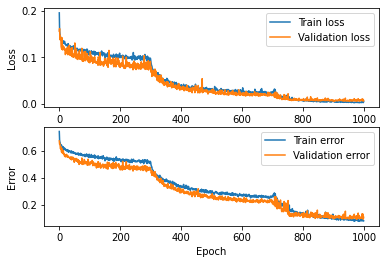

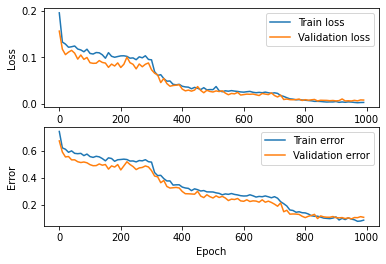

In [46]:
## Plot loss and error
## Every epochs
plt.subplot(2,1,1)
plt.plot(losses_train, label = 'Train loss')
plt.plot(losses_val, label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(error_train, label = 'Train error')
plt.plot(error_val, label = 'Validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()
## Every 10 epochs
plt.subplot(2,1,1)
plt.plot(np.arange(0,999,10),losses_train[::10], label = 'Train loss')
plt.plot(np.arange(0,999,10),losses_val[::10], label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.arange(0,999,10),error_train[::10], label = 'Train error')
plt.plot(np.arange(0,999,10),error_val[::10], label = 'Validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()


In [48]:
loss_test, mae_test = evaluate(model, test_loader)
print('MAE for test: %.4f eV' %mae_test)

MAE for test: 0.0873 eV


In [49]:
torch.save(model.state_dict(),'T0')

In [42]:
## Test saved model
dataset = CIFData('cif_merge')
collate_fn = collate_pool
train_loader, val_loader, test_loader = get_train_val_test_loader(dataset=dataset, collate_fn=collate_fn, batch_size=10, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, pin_memory=gpu_boole, num_workers=0, return_test=True, train_size=None, test_size=None, val_size=None)

checkpoint = torch.load('T0')
model.load_state_dict(checkpoint)
loss_test, mae_test = evaluate(model, test_loader)
print('MAE for test: %.4f eV' %mae_test)

MAE for test: 0.0693 eV
